In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline
import folium
from folium.plugins import MarkerCluster
from folium import FeatureGroup, LayerControl
from folium.features import GeoJson
from shapely.geometry import shape, Point
import json
from urllib.parse import urlparse, urlunparse, parse_qs, urlencode

# URL에 쿼리 파라미터를 추가하는 함수
def modify_url(url, params):
    url_parts = list(urlparse(url))
    query = dict(parse_qs(url_parts[4]))
    query.update(params)
    url_parts[4] = urlencode(query, doseq=True)
    return urlunparse(url_parts)

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

path = '../../../../../datasets/london_listings.csv'

raw = pd.read_csv(path)
df = raw.copy()

df = df[['id', 'host_id','host_is_superhost',
        'host_total_listings_count','neighbourhood_cleansed','room_type','accommodates','bathrooms','bedrooms',
        'beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 
        'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_location', 'review_scores_value', 'reviews_per_month','listing_url','property_type','number_of_reviews_ltm','has_availability','last_review']]

df = df.rename(columns= {
    'id': '숙소_id',
    'host_id': '호스트_id',
    'host_is_superhost': '슈퍼호스트',
    'host_total_listings_count': '숙소_수',
    'neighbourhood_cleansed': '숙소_지역',
    'room_type': '숙소_유형',
    'accommodates': '수용_인원수',
    'bathrooms': '욕실수',
    'bedrooms': '침실수',
    'beds': '침대수',
    'amenities': '편의시설',
    'price': '숙소_가격',
    'minimum_nights': '최소_숙박일',
    'maximum_nights': '최대_숙박일',
    'number_of_reviews': '리뷰수',
    'number_of_reviews_l30d': '30일_리뷰수',
    'review_scores_rating': '리뷰점수',
    'review_scores_accuracy': '숙소_정확성_리뷰점수',
    'review_scores_cleanliness': '숙소_청결도_리뷰점수',
    'review_scores_checkin': '숙소_체크인_리뷰점수',
    'review_scores_communication': '숙소_소통_리뷰점수',
    'review_scores_location': '숙소_위치_리뷰점수',
    'review_scores_value': '숙소_가격_리뷰점수',
    'reviews_per_month': '평균_리뷰수',
    'listing_url':'url',
    'property_type':'숙소_특징',
    'number_of_reviews_ltm':'12개월_리뷰수',
    'has_availability':'예약가능여부',
    'last_review':'마지막_리뷰'
})
df['위도']=raw['latitude']
df['경도']=raw['longitude']
print(len(df[df['리뷰수']==0]))
# 슈퍼호스트, 리뷰수 결측치 제거
print(f"처음 df : {len(df)}")
df = df[~df['슈퍼호스트'].isnull()]
print(f"슈퍼호스트 제거 : {len(df)}")
df = df[df['리뷰수']>2]
print(f"리뷰수 제거 : {len(df)}")

# 숙소가격 null값 제거
df= df[~df['숙소_가격'].isnull()]

#가격 앞 통화기호 제거
df['숙소_가격'] = df['숙소_가격'].replace('[\$,]', '', regex=True).astype(float)

# 유형 제거 
df = df[(df['숙소_유형']=='Entire home/apt') | (df['숙소_유형']=='Private room')]
print(f"숙소_유형 제거 : {len(df)}")

# 12개월 리뷰수 0 개 제거
df = df[df['12개월_리뷰수']!=0]
print(f"12개월_리뷰수 0개 제거 : {len(df)}")

# 욕실수, 침실수, 침대수 null값 제거
df = df.dropna(subset=['욕실수', '침실수', '침대수'])
print(f"욕실수, 침실수, 침대수 제거 후 : {len(df)}")

# 리뷰  null값 제거
df = df.dropna(subset=['숙소_정확성_리뷰점수','숙소_청결도_리뷰점수','숙소_체크인_리뷰점수','숙소_소통_리뷰점수','숙소_위치_리뷰점수','숙소_가격_리뷰점수'])
print(f"리뷰 결측치 제거 후 : {len(df)}")

# 예약 가능여부 f 버리기
df = df.dropna(subset='예약가능여부')
print(f"예약가능여부 : {len(df)}")


24983
처음 df : 90852
슈퍼호스트 제거 : 90463
리뷰수 제거 : 50711
숙소_유형 제거 : 34776
12개월_리뷰수 0개 제거 : 31852
욕실수, 침실수, 침대수 제거 후 : 31781
리뷰 결측치 제거 후 : 31781
예약가능여부 : 31779


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import font_manager, rc
%matplotlib inline

# 글꼴 경로 지정
font_path = "c:/Windows/Fonts/malgun.ttf"  # 윈도우에 설치된 맑은 고딕 폰트 경로

# 폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

# matplotlib의 rc(run command) 기능을 이용하여 글꼴 설정
mpl.rc('font', family=font_name)

# 유니코드에서  음수 부호 설정
mpl.rc('axes', unicode_minus=False)

df_guest_prefer = pd.read_csv('../../../../../datasets/paris_prefer.csv')
df_non_guest_prefer= pd.read_csv('../../../../../datasets/paris_non_prefer.csv')

In [22]:
import pandas as pd

# df_guest_prefer에서 랜덤으로 데이터 선택하여 새 데이터프레임 생성
df_random_guest_prefer = df.sample(n=len(df_guest_prefer), replace=False)

# 모든 편의시설을 파싱하여 유니크한 편의시설 세트 생성
amenities_set_random = set()

# 편의시설 열이 데이터프레임에 존재하는지 확인
if '편의시설' in df_random_guest_prefer.columns:
    df_random_guest_prefer['편의시설'].apply(lambda x: amenities_set_random.update(eval(x)))

    # 각 편의시설에 대해 이진 특성 열을 데이터프레임에 추가
    for amenity in amenities_set_random:
        df_random_guest_prefer[amenity] = df_random_guest_prefer['편의시설'].apply(lambda x: amenity in eval(x))

    # '편의시설' 열 삭제
    df_random_guest_prefer.drop('편의시설', axis=1, inplace=True)
else:
    print("편의시설 열이 존재하지 않습니다.")


C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\3427263704.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_random_guest_prefer[amenity] = df_random_guest_prefer['편의시설'].apply(lambda x: amenity in eval(x))
C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\3427263704.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_random_guest_prefer[amenity] = df_random_guest_prefer['편의시설'].apply(lambda x: amenity in eval(x))
C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\3427263704.py:15: PerformanceWarning: DataFrame is highly

In [27]:
df_random_guest_prefer.to_csv('../../../../../datasets/guest_random_prefer.csv', index=False, encoding='utf-8-sig')

UnicodeEncodeError: 'utf-8' codec can't encode characters in position 60322-60323: surrogates not allowed

In [32]:
# 모든 열 이름을 소문자로 변환하여 찾기
tv_columns = [col for col in df_guest_prefer.columns if 'tv' in col.lower()]
wifi_columns = [col for col in df_guest_prefer.columns if 'wifi' in col.lower()]
shampoo_columns = [
    col for col in df_guest_prefer.columns if 'body soap' in col.lower() or 'shampoo' in col.lower() or 'conditioner' in col.lower()
]
oven_columns = [col for col in df_guest_prefer.columns if 'oven' in col.lower()]
stove_columns = [col for col in df_guest_prefer.columns if 'stove' in col.lower()]
housekeeping_columns = [col for col in df_guest_prefer.columns if 'housekeeping' in col.lower()]
sound_columns = [col for col in df_guest_prefer.columns if 'sound' in col.lower()]
refrigerator_columns = [col for col in df_guest_prefer.columns if 'refrigerator' in col.lower()]
parking_columns = [col for col in df_guest_prefer.columns if 'parking' in col.lower()]
weights_columns = [
    col for col in df_guest_prefer.columns if 'weights' in col.lower() or 'exercise' in col.lower() or 'gym' in col.lower()
]
game_columns = [col for col in df_guest_prefer.columns if 'game' in col.lower() ]
coffee_columns = [col for col in df_guest_prefer.columns if 'coffee' in col.lower() ]
pool_columns = [col for col in df_guest_prefer.columns if 'pool' in col.lower() ]

# 개수 확인
print(f"tv_columns  개수 : {len(tv_columns)}")
print(f"wifi_columns  개수 : {len(wifi_columns)}")
print(f"shampoo_columns  개수 : {len(shampoo_columns)}")
print(f"oven_columns  개수 : {len(oven_columns)}")
print(f"stove_columns  개수 : {len(stove_columns)}")
print(f"housekeeping_columns  개수 : {len(housekeeping_columns)}")
print(f"sound_columns  개수 : {len(sound_columns)}")
print(f"refrigerator_columns  개수 : {len(refrigerator_columns)}")
print(f"parking_columns  개수 : {len(parking_columns)}")
print(f"weights_columns  개수 : {len(weights_columns)}")
print(f"game_columns  개수 : {len(game_columns)}")
print(f"coffee_columns  개수 : {len(coffee_columns)}")
print(f"pool_columns  개수 : {len(pool_columns)}")

# 하나의  열 생성
df_guest_prefer['tv'] = df_guest_prefer[tv_columns].any(axis=1)
df_guest_prefer['wifi'] = df_guest_prefer[wifi_columns].any(axis=1)
df_guest_prefer['shampoo'] = df_guest_prefer[shampoo_columns].any(axis=1)
df_guest_prefer['oven'] = df_guest_prefer[oven_columns].any(axis=1)
df_guest_prefer['stove'] = df_guest_prefer[stove_columns].any(axis=1)
df_guest_prefer['housekeeping'] = df_guest_prefer[housekeeping_columns].any(axis=1)
df_guest_prefer['sound'] = df_guest_prefer[sound_columns].any(axis=1)
df_guest_prefer['refrigerator'] = df_guest_prefer[refrigerator_columns].any(axis=1)
df_guest_prefer['parking'] = df_guest_prefer[parking_columns].any(axis=1)
df_guest_prefer['weights'] = df_guest_prefer[weights_columns].any(axis=1)
df_guest_prefer['game'] = df_guest_prefer[game_columns].any(axis=1)
df_guest_prefer['coffee'] = df_guest_prefer[coffee_columns].any(axis=1)
df_guest_prefer['pool'] = df_guest_prefer[pool_columns].any(axis=1)



# 모든 열 리스트를 하나로 합치기
all_columns_to_drop = tv_columns + wifi_columns + shampoo_columns + oven_columns + stove_columns + housekeeping_columns + sound_columns + refrigerator_columns + parking_columns + weights_columns + game_columns + coffee_columns + pool_columns

# 리스트에서 중복 제거
columns_to_drop = list(set(all_columns_to_drop))

# 일괄 삭제
df_guest_prefer.drop(columns=columns_to_drop, inplace=True)


tv_columns  개수 : 629
wifi_columns  개수 : 491
shampoo_columns  개수 : 614
oven_columns  개수 : 222
stove_columns  개수 : 135
housekeeping_columns  개수 : 19
sound_columns  개수 : 255
refrigerator_columns  개수 : 145
parking_columns  개수 : 32
weights_columns  개수 : 25
game_columns  개수 : 19
coffee_columns  개수 : 35
pool_columns  개수 : 36


In [33]:
# 모든 열 이름을 소문자로 변환하여 찾기
tv_columns = [col for col in df_non_guest_prefer.columns if 'tv' in col.lower()]
wifi_columns = [col for col in df_non_guest_prefer.columns if 'wifi' in col.lower()]
shampoo_columns = [
    col for col in df_non_guest_prefer.columns if 'body soap' in col.lower() or 'shampoo' in col.lower() or 'conditioner' in col.lower()
]
oven_columns = [col for col in df_non_guest_prefer.columns if 'oven' in col.lower()]
stove_columns = [col for col in df_non_guest_prefer.columns if 'stove' in col.lower()]
housekeeping_columns = [col for col in df_non_guest_prefer.columns if 'housekeeping' in col.lower()]
sound_columns = [col for col in df_non_guest_prefer.columns if 'sound' in col.lower()]
refrigerator_columns = [col for col in df_non_guest_prefer.columns if 'refrigerator' in col.lower()]
parking_columns = [col for col in df_non_guest_prefer.columns if 'parking' in col.lower()]
weights_columns = [
    col for col in df_non_guest_prefer.columns if 'weights' in col.lower() or 'exercise' in col.lower() or 'gym' in col.lower()
]
game_columns = [col for col in df_non_guest_prefer.columns if 'game' in col.lower() ]
coffee_columns = [col for col in df_non_guest_prefer.columns if 'coffee' in col.lower() ]
pool_columns = [col for col in df_non_guest_prefer.columns if 'pool' in col.lower() ]

# 개수 확인
print(f"tv_columns  개수 : {len(tv_columns)}")
print(f"wifi_columns  개수 : {len(wifi_columns)}")
print(f"shampoo_columns  개수 : {len(shampoo_columns)}")
print(f"oven_columns  개수 : {len(oven_columns)}")
print(f"stove_columns  개수 : {len(stove_columns)}")
print(f"housekeeping_columns  개수 : {len(housekeeping_columns)}")
print(f"sound_columns  개수 : {len(sound_columns)}")
print(f"refrigerator_columns  개수 : {len(refrigerator_columns)}")
print(f"parking_columns  개수 : {len(parking_columns)}")
print(f"weights_columns  개수 : {len(weights_columns)}")
print(f"game_columns  개수 : {len(game_columns)}")
print(f"coffee_columns  개수 : {len(coffee_columns)}")
print(f"pool_columns  개수 : {len(pool_columns)}")

# 하나의  열 생성
df_non_guest_prefer['tv'] = df_non_guest_prefer[tv_columns].any(axis=1)
df_non_guest_prefer['wifi'] = df_non_guest_prefer[wifi_columns].any(axis=1)
df_non_guest_prefer['shampoo'] = df_non_guest_prefer[shampoo_columns].any(axis=1)
df_non_guest_prefer['oven'] = df_non_guest_prefer[oven_columns].any(axis=1)
df_non_guest_prefer['stove'] = df_non_guest_prefer[stove_columns].any(axis=1)
df_non_guest_prefer['housekeeping'] = df_non_guest_prefer[housekeeping_columns].any(axis=1)
df_non_guest_prefer['sound'] = df_non_guest_prefer[sound_columns].any(axis=1)
df_non_guest_prefer['refrigerator'] = df_non_guest_prefer[refrigerator_columns].any(axis=1)
df_non_guest_prefer['parking'] = df_non_guest_prefer[parking_columns].any(axis=1)
df_non_guest_prefer['weights'] = df_non_guest_prefer[weights_columns].any(axis=1)
df_non_guest_prefer['game'] = df_non_guest_prefer[game_columns].any(axis=1)
df_non_guest_prefer['coffee'] = df_non_guest_prefer[coffee_columns].any(axis=1)
df_non_guest_prefer['pool'] = df_non_guest_prefer[pool_columns].any(axis=1)



# 모든 열 리스트를 하나로 합치기
all_columns_to_drop = tv_columns + wifi_columns + shampoo_columns + oven_columns + stove_columns + housekeeping_columns + sound_columns + refrigerator_columns + parking_columns + weights_columns + game_columns + coffee_columns + pool_columns

# 리스트에서 중복 제거
columns_to_drop = list(set(all_columns_to_drop))

# 일괄 삭제
df_non_guest_prefer.drop(columns=columns_to_drop, inplace=True)


tv_columns  개수 : 237
wifi_columns  개수 : 151
shampoo_columns  개수 : 202
oven_columns  개수 : 69
stove_columns  개수 : 54
housekeeping_columns  개수 : 7
sound_columns  개수 : 61
refrigerator_columns  개수 : 68
parking_columns  개수 : 24
weights_columns  개수 : 14
game_columns  개수 : 17
coffee_columns  개수 : 25
pool_columns  개수 : 20


In [30]:
# 모든 열 이름을 소문자로 변환하여 찾기
tv_columns = [col for col in df_random_guest_prefer.columns if 'tv' in col.lower()]
wifi_columns = [col for col in df_random_guest_prefer.columns if 'wifi' in col.lower()]
shampoo_columns = [
    col for col in df_random_guest_prefer.columns if 'body soap' in col.lower() or 'shampoo' in col.lower() or 'conditioner' in col.lower()
]
oven_columns = [col for col in df_random_guest_prefer.columns if 'oven' in col.lower()]
stove_columns = [col for col in df_random_guest_prefer.columns if 'stove' in col.lower()]
housekeeping_columns = [col for col in df_random_guest_prefer.columns if 'housekeeping' in col.lower()]
sound_columns = [col for col in df_random_guest_prefer.columns if 'sound' in col.lower()]
refrigerator_columns = [col for col in df_random_guest_prefer.columns if 'refrigerator' in col.lower()]
parking_columns = [col for col in df_random_guest_prefer.columns if 'parking' in col.lower()]
weights_columns = [
    col for col in df_random_guest_prefer.columns if 'weights' in col.lower() or 'exercise' in col.lower() or 'gym' in col.lower()
]
game_columns = [col for col in df_random_guest_prefer.columns if 'game' in col.lower() ]
coffee_columns = [col for col in df_random_guest_prefer.columns if 'coffee' in col.lower() ]
pool_columns = [col for col in df_random_guest_prefer.columns if 'pool' in col.lower() ]

# 개수 확인
print(f"tv_columns  개수 : {len(tv_columns)}")
print(f"wifi_columns  개수 : {len(wifi_columns)}")
print(f"shampoo_columns  개수 : {len(shampoo_columns)}")
print(f"oven_columns  개수 : {len(oven_columns)}")
print(f"stove_columns  개수 : {len(stove_columns)}")
print(f"housekeeping_columns  개수 : {len(housekeeping_columns)}")
print(f"sound_columns  개수 : {len(sound_columns)}")
print(f"refrigerator_columns  개수 : {len(refrigerator_columns)}")
print(f"parking_columns  개수 : {len(parking_columns)}")
print(f"weights_columns  개수 : {len(weights_columns)}")
print(f"game_columns  개수 : {len(game_columns)}")
print(f"coffee_columns  개수 : {len(coffee_columns)}")
print(f"pool_columns  개수 : {len(pool_columns)}")

# 하나의  열 생성
df_random_guest_prefer['tv'] = df_random_guest_prefer[tv_columns].any(axis=1)
df_random_guest_prefer['wifi'] = df_random_guest_prefer[wifi_columns].any(axis=1)
df_random_guest_prefer['shampoo'] = df_random_guest_prefer[shampoo_columns].any(axis=1)
df_random_guest_prefer['oven'] = df_random_guest_prefer[oven_columns].any(axis=1)
df_random_guest_prefer['stove'] = df_random_guest_prefer[stove_columns].any(axis=1)
df_random_guest_prefer['housekeeping'] = df_random_guest_prefer[housekeeping_columns].any(axis=1)
df_random_guest_prefer['sound'] = df_random_guest_prefer[sound_columns].any(axis=1)
df_random_guest_prefer['refrigerator'] = df_random_guest_prefer[refrigerator_columns].any(axis=1)
df_random_guest_prefer['parking'] = df_random_guest_prefer[parking_columns].any(axis=1)
df_random_guest_prefer['weights'] = df_random_guest_prefer[weights_columns].any(axis=1)
df_random_guest_prefer['game'] = df_random_guest_prefer[game_columns].any(axis=1)
df_random_guest_prefer['coffee'] = df_random_guest_prefer[coffee_columns].any(axis=1)
df_random_guest_prefer['pool'] = df_random_guest_prefer[pool_columns].any(axis=1)



# 모든 열 리스트를 하나로 합치기
all_columns_to_drop = tv_columns + wifi_columns + shampoo_columns + oven_columns + stove_columns + housekeeping_columns + sound_columns + refrigerator_columns + parking_columns + weights_columns + game_columns + coffee_columns + pool_columns

# 리스트에서 중복 제거
columns_to_drop = list(set(all_columns_to_drop))

# 일괄 삭제
df_random_guest_prefer.drop(columns=columns_to_drop, inplace=True)


tv_columns  개수 : 569
wifi_columns  개수 : 227
shampoo_columns  개수 : 506
oven_columns  개수 : 149
stove_columns  개수 : 140
housekeeping_columns  개수 : 7
sound_columns  개수 : 110
refrigerator_columns  개수 : 120
parking_columns  개수 : 34
weights_columns  개수 : 26
game_columns  개수 : 18
coffee_columns  개수 : 34
pool_columns  개수 : 14


C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\1003013857.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_random_guest_prefer['tv'] = df_random_guest_prefer[tv_columns].any(axis=1)
C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\1003013857.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_random_guest_prefer['wifi'] = df_random_guest_prefer[wifi_columns].any(axis=1)
C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\1003013857.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

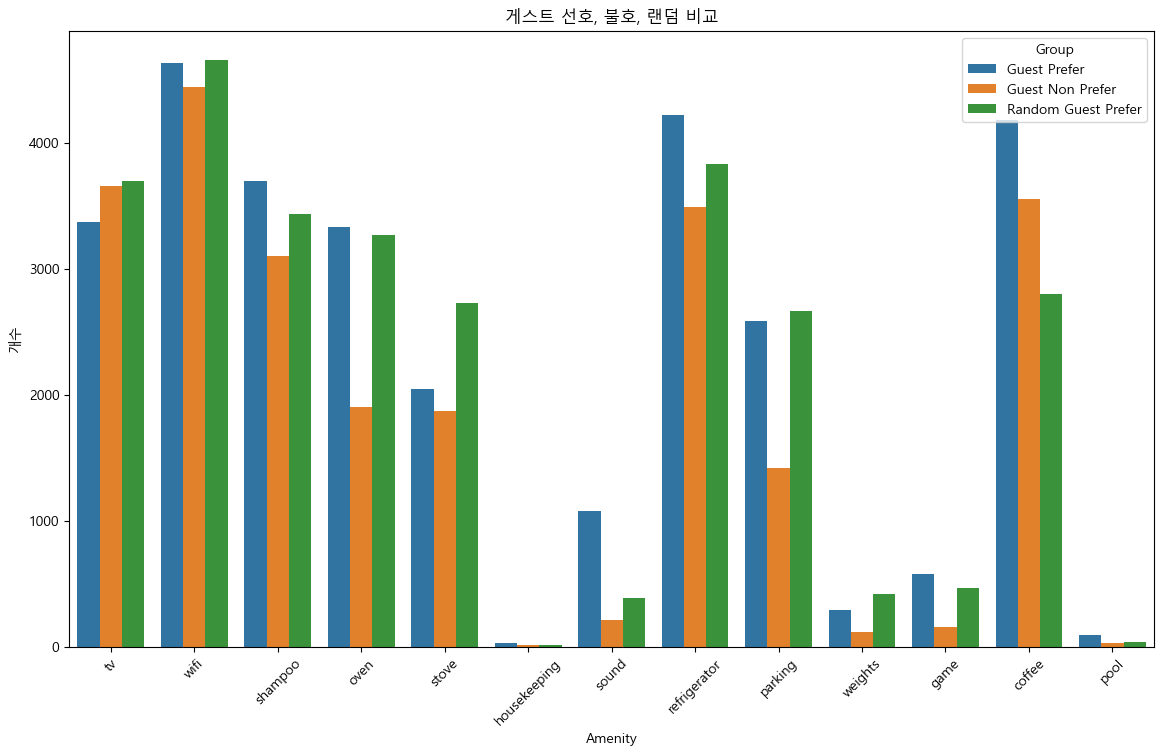

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 편의시설 요소 목록
amenities = ['tv', 'wifi', 'shampoo', 'oven', 'stove', 'housekeeping', 'sound', 'refrigerator', 'parking', 'weights', 'game', 'coffee', 'pool']

# 각 데이터프레임에 대해 편의시설의 True 개수를 계산하고 비교
results = []

for amenity in amenities:
    prefer_count = df_guest_prefer[amenity].sum()
    non_prefer_count = df_non_guest_prefer[amenity].sum()
    random_prefer_count = df_random_guest_prefer[amenity].sum()  # 랜덤 게스트 선호 데이터 추가
    results.append({
        'Amenity': amenity,
        'Guest Prefer': prefer_count,
        'Guest Non Prefer': non_prefer_count,
        'Random Guest Prefer': random_prefer_count  # 결과에 추가
    })

# 결과 DataFrame 생성
comparison_df = pd.DataFrame(results)
comparison_df_melted = comparison_df.melt(id_vars='Amenity', value_vars=['Guest Prefer', 'Guest Non Prefer', 'Random Guest Prefer'], var_name='Type', value_name='Counts')

# 시각화
plt.figure(figsize=(14, 8))
sns.barplot(x='Amenity', y='Counts', hue='Type', data=comparison_df_melted)

plt.xticks(rotation=45)
plt.ylabel('개수')
plt.title('게스트 선호, 불호, 랜덤 비교')
plt.legend(title='Group')
plt.show()


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 세 데이터프레임 합치기
df_combined = pd.concat([df_guest_prefer, df_non_guest_prefer, df_random_guest_prefer], ignore_index=True)

# 편의시설 리스트
amenities = ['tv', 'wifi', 'shampoo', 'oven', 'stove', 'housekeeping', 'sound', 'refrigerator', 'parking', 'weights', 'game', 'coffee', 'pool']

# 결과를 저장할 데이터프레임 생성
df_amenities_scores = pd.DataFrame(columns=['편의시설', 'Guest O_평균점수', 'Guest X_평균점수', 'Non-Guest O_평균점수', 'Non-Guest X_평균점수', 'Random O_평균점수', 'Random X_평균점수'])

# 각 데이터프레임과 편의시설 별로 평균 점수 차이 계산
for amenity in amenities:
    mean_score_with_guest = df_guest_prefer[df_guest_prefer[amenity] == True]['리뷰점수'].mean()
    mean_score_without_guest = df_guest_prefer[df_guest_prefer[amenity] == False]['리뷰점수'].mean()
    mean_score_with_non_guest = df_non_guest_prefer[df_non_guest_prefer[amenity] == True]['리뷰점수'].mean()
    mean_score_without_non_guest = df_non_guest_prefer[df_non_guest_prefer[amenity] == False]['리뷰점수'].mean()
    mean_score_with_random = df_random_guest_prefer[df_random_guest_prefer[amenity] == True]['리뷰점수'].mean()
    mean_score_without_random = df_random_guest_prefer[df_random_guest_prefer[amenity] == False]['리뷰점수'].mean()
    
    # 결과 데이터프레임 업데이트
    new_row = pd.DataFrame({
        '편의시설': [amenity],
        'Guest O_평균점수': [mean_score_with_guest],
        'Guest X_평균점수': [mean_score_without_guest],
        'Non-Guest O_평균점수': [mean_score_with_non_guest],
        'Non-Guest X_평균점수': [mean_score_without_non_guest],
        'Random O_평균점수': [mean_score_with_random],
        'Random X_평균점수': [mean_score_without_random]
    })
    df_amenities_scores = pd.concat([df_amenities_scores, new_row], ignore_index=True)

# 전체 평균 점수 추가
df_amenities_scores['전체 평균 점수'] = (df_amenities_scores[['Guest O_평균점수', 'Guest X_평균점수', 'Non-Guest O_평균점수', 'Non-Guest X_평균점수', 'Random O_평균점수', 'Random X_평균점수']].mean(axis=1))

# 결과 출력
print(df_amenities_scores)



            편의시설  Guest O_평균점수  Guest X_평균점수  Non-Guest O_평균점수  \
0             tv      4.957823      4.958305          4.302588   
1           wifi      4.958098      4.949744          4.308736   
2        shampoo      4.957749      4.958725          4.312498   
3           oven      4.958821      4.955889          4.323969   
4          stove      4.953350      4.961508          4.321406   
5   housekeeping      4.958235      4.957958          4.248571   
6          sound      4.961095      4.957031          4.350783   
7   refrigerator      4.957924      4.958266          4.316220   
8        parking      4.957326      4.958731          4.325807   
9        weights      4.959141      4.957882          4.339231   
10          game      4.964523      4.957045          4.328625   
11        coffee      4.957581      4.960912          4.315992   
12          pool      4.954949      4.958025          4.332581   

    Non-Guest X_평균점수  Random O_평균점수  Random X_평균점수  전체 평균 점수  
0           

C:\Users\ciw96\AppData\Local\Temp\ipykernel_1168\868335525.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_amenities_scores = pd.concat([df_amenities_scores, new_row], ignore_index=True)


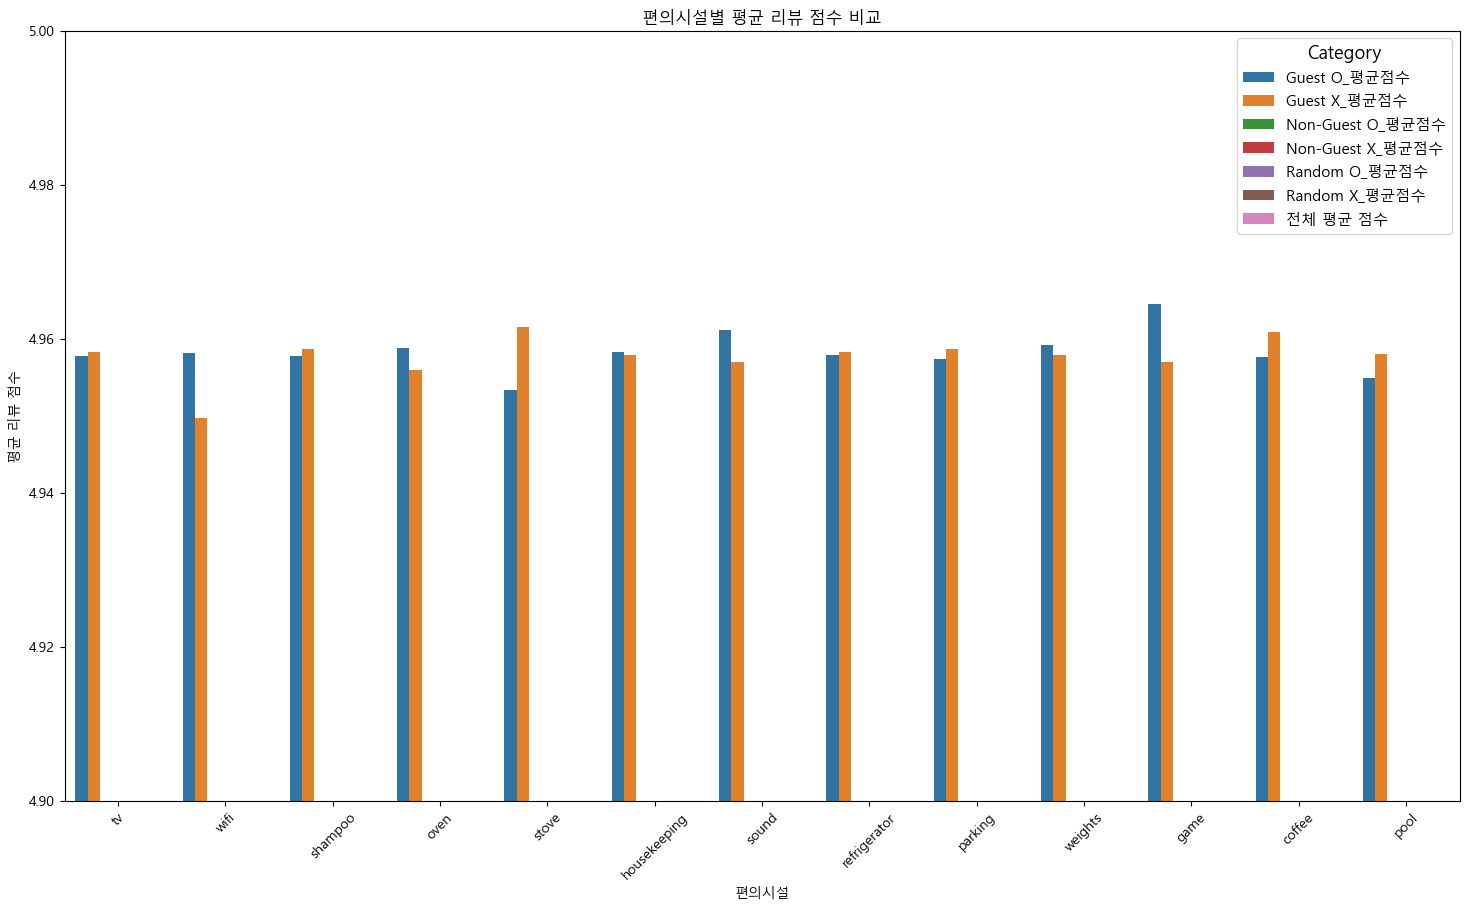

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 결과 데이터프레임을 long format으로 변환
df_amenities_scores_long = df_amenities_scores.melt(id_vars='편의시설', var_name='Category', value_name='Average Score')

# 시각화
plt.figure(figsize=(18, 10))
sns.barplot(x='편의시설', y='Average Score', hue='Category', data=df_amenities_scores_long)

plt.xticks(rotation=45)
plt.ylabel('평균 리뷰 점수')
plt.title('편의시설별 평균 리뷰 점수 비교')
plt.legend(title='Category', title_fontsize='13', fontsize='11')
# y축 시작점을 4로 설정
plt.ylim(4.9, 5)  
plt.show()


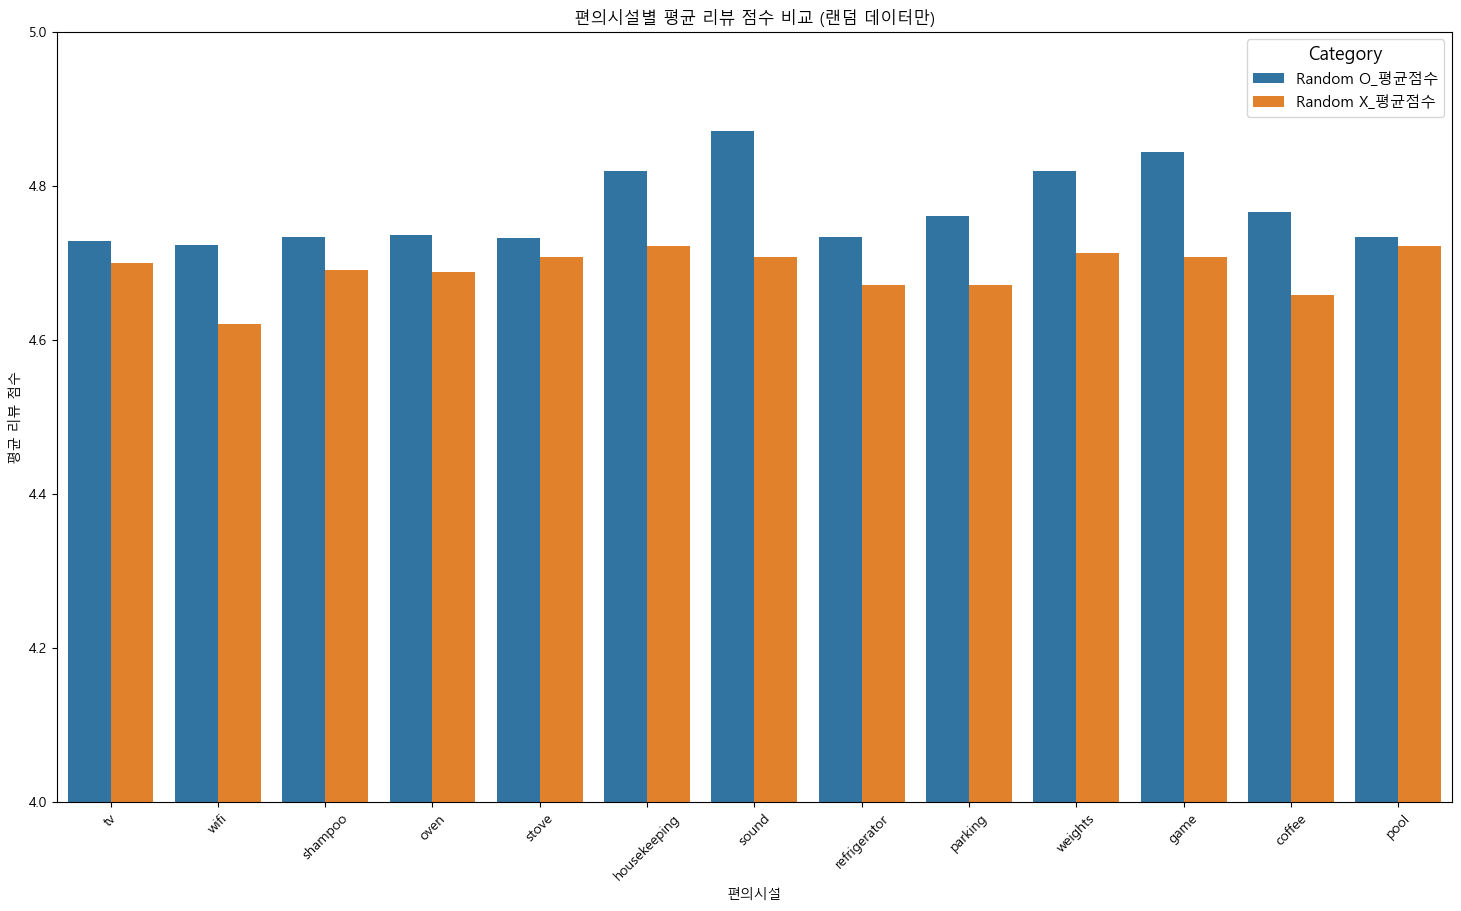

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 데이터만 필터링
df_random_only = df_amenities_scores_long[df_amenities_scores_long['Category'].str.contains('Random')]

# 시각화
plt.figure(figsize=(18, 10))
sns.barplot(x='편의시설', y='Average Score', hue='Category', data=df_random_only)

plt.xticks(rotation=45)
plt.ylabel('평균 리뷰 점수')
plt.title('편의시설별 평균 리뷰 점수 비교 (랜덤 데이터만)')
plt.legend(title='Category', title_fontsize='13', fontsize='11')

# y축 시작점을 4로 설정
plt.ylim(4, 5)  

plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 데이터만 필터링
df_random_only = df_amenities_scores_long[df_amenities_scores_long['Category'].str.contains('Random')]

# 시각화
plt.figure(figsize=(18, 10))
sns.barplot(x='편의시설', y='Average Score', hue='Category', data=df_random_only)

plt.xticks(rotation=45)
plt.ylabel('평균 리뷰 점수')
plt.title('편의시설별 평균 리뷰 점수 비교 (랜덤 데이터만)')
plt.legend(title='Category', title_fontsize='13', fontsize='11')

# y축 시작점을 4로 설정
plt.ylim(4, 5)  

plt.show()
